In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

c:\Codes\Learning\Lang_graph\venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [ ]:
load_dotenv()

In [21]:
subgraph_llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [22]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [23]:
def translate_text(state: SubState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["input_text"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

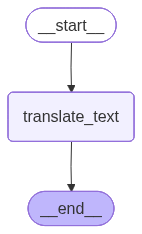

In [24]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()
subgraph

In [25]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str

In [26]:
parent_llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [27]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [28]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [29]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

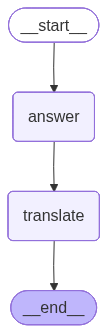

In [30]:
graph = parent_builder.compile()

graph

In [31]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics, also known as quantum mechanics, is the study of the world at the smallest scales of energy levels of atoms and subatomic particles. It reveals that many aspects of nature behave very differently from how they work at a macroscopic, observable scale.\n\nHere\'s a breakdown of key concepts:\n\n*   **Quantization:** Energy, like light, isn\'t continuous but comes in discrete packets called "quanta." Think of it like stairs versus a ramp.\n\n*   **Wave-Particle Duality:** Particles, like electrons, can exhibit wave-like properties, and waves, like light, can exhibit particle-like properties.\n\n*   **Superposition:** A quantum system can exist in multiple states simultaneously until measured.\n\n*   **Uncertainty Principle:** There\'s a fundamental limit to how precisely certain pairs of physical properties, like position and momentum, can be known simultaneously.\n\n*   **Entanglement:** Two or more particles can be